# Reverberation Estimation Time Test


In [1]:
# Import Systems 
import struct
import io
import os
import sys
import time
import platform

# Import Audio
import pyaudio
import librosa
import soundfile

import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt

# User Libraries
import pyOssWavfile
import pyOssFilter
import pyRoomAcoustic as room
import pyOssDebug as dbg
import pyroomacoustics as pyroom


In [2]:
###########################################################
# Load Impulse
###########################################################
# imp_dir = 'ju_impulse'         # 임펄스 음원 파일이 있는 프로젝트 내 폴더명
imp_dir = 'impulsefiles'

# SET IMPULSE WAVE FILE NAME IN 'impulsefiles' DIRECTORY
# imp_name = "StairwayUniversityOfYork"
imp_name = "mh3_000_ortf_48k"

# IMPULSE WAVE FILE NAME IN 'ju_impulse' DIRECTORY
# imp_name = 'ju_imp_goyang_aramnuri_concerthall'
# imp_name = 'Impulse_201125_JU_SoundLab_Ori_mono_48k_32i'
# imp_name = 'Impulse_201125_JU_SoundLab_Aram_mono_48k_32i'
# imp_name = 'Impulse_201125_JU_SoundLab_Daegu_mono_48k_32i'
# imp_name = 'Impulse_201125_JU_SoundLab_Sejong_mono_48k_32i'


# 파일명 조합
imp_fname = pyOssWavfile.str_fname(imp_dir, imp_name)

# Check Impulse Wav file header information
st_fmt_i = pyOssWavfile.extractWavFmtChunk( pyOssWavfile.read_format(imp_fname) )
dbg.dWavInfo(st_fmt_i)

# Load Original Audio & Convert format mono / float32 / 44.1kHz 
chunk_i, data_i, st_fmt_i, t_i = pyOssWavfile.readf32( imp_fname )
dbg.dWavInfo(st_fmt_i)          # for debug (print wav header)
print(f"Time(sec) =", t_i)


Audio Format = Int
Number of Channel = 1
Sampling Frequency = 48000
Bits per Sample = 16
Audio Format = float
Number of Channel = 1
Sampling Frequency = 44100
Bits per Sample = 32
Time(sec) = 5.461337868480726


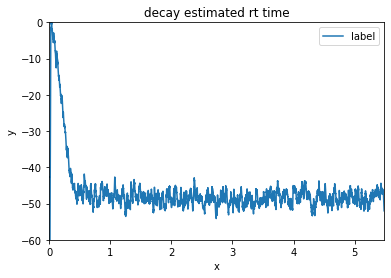

Label:  decay estimate rt
 - Decay Time  0 ~ -10dB =  0.09300000000000001
 - Decay Time -5 ~ -25dB =  0.151
 - Decay Time -5 ~ -35dB =  0.215
 - EDT =  0.558
 - T20 =  0.45299999999999996
 - T30 =  0.43
 - RT60(=T30) =  0.43
 - D50 =  0.59941155
 - C50 =  1.7502690851688385
 - C80 =  6.69273316860199
Label:  decay pyroom.sabine rt
 - Decay Time  0 ~ -10dB =  0.09300000000000001
 - Decay Time -5 ~ -25dB =  0.151
 - Decay Time -5 ~ -35dB =  0.215
 - EDT =  0.558
 - T20 =  0.45299999999999996
 - T30 =  0.43
 - RT60(=T30) =  0.43
 - D50 =  0.59941155
 - C50 =  1.7502690851688385
 - C80 =  6.69273316860199
Label:  decay pyroom.eyring rt
 - Decay Time  0 ~ -10dB =  0.09000000000000001
 - Decay Time -5 ~ -25dB =  0.155
 - Decay Time -5 ~ -35dB =  0.218
 - EDT =  0.54
 - T20 =  0.46499999999999997
 - T30 =  0.436
 - RT60(=T30) =  0.436
 - D50 =  0.59941155
 - C50 =  1.7502690851688385
 - C80 =  6.69273316860199
 - RT60 =  0.43
 - EDT =  0.558
 - D50 =  0.59941155
 - C50 =  1.7502690851688385
 

In [3]:
rm_width = 8.45     # JU SoundLab 가로길이
rm_depth = 7.61     # JU SoundLab 세로길이
rm_height = 2.64    # JU SoundLab 높이
alpha = 0.31        # JU SoundLab 추정 벽면 흡음률 (재질: 아트보드 9T의 NRC값)

estimated_rt, V, S, K, A = room.rt60_sabine(rm_depth, rm_depth, rm_height, 20, w_absl=alpha)
sabine_rt = pyroom.acoustics.rt60_sabine(S, V, alpha, m=0, c=room.soundspeed(20))
eyring_rt = pyroom.acoustics.rt60_eyring(S, V, alpha, m=0, c=room.soundspeed(20))

fc = 500            # Octave Band at 500 Hz
# fc = 0              # No Filter
data_filt, decay, a_param = pyOssFilter.calc_filt_impulse(data_i, st_fmt_i.fs, fc, estimated_rt, filt_type='fir', order_tab=1024, fname=imp_name)

decay_t_i_es = room.decayCurve(data_filt, estimated_rt, st_fmt_i.fs)
decay_t_i_sb = room.decayCurve(data_filt, sabine_rt, st_fmt_i.fs)
decay_t_i_ey = room.decayCurve(data_filt, eyring_rt, st_fmt_i.fs)

dbg.dPlotDecay(st_fmt_i.fs, decay_t_i_es, title_txt='decay estimated rt time')

room.calcAcousticParam( data_filt, decay_t_i_es, st_fmt_i.fs, printout=True, label_text='decay estimate rt' )
room.calcAcousticParam( data_filt, decay_t_i_sb, st_fmt_i.fs, printout=True, label_text='decay pyroom.sabine rt' )
room.calcAcousticParam( data_filt, decay_t_i_ey, st_fmt_i.fs, printout=True, label_text='decay pyroom.eyring rt' )


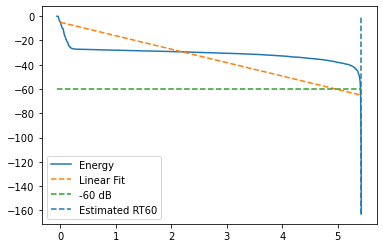

5.411451247165533


In [4]:
rt = pyroom.experimental.rt60.measure_rt60(data_filt, st_fmt_i.fs, plot=True)
print(rt)